In this example, we compare Scrublet predictions to "ground truth" doublet calls made by Demuxlet, a method that uses genotype information to demultiplex data and identify doublets. We also test two different methods of data normalization (upstream of Scrublet) to see which produces better doublet predictions.  

For more information on Demuxlet, see the paper:  
Kang, H. M. et al. Multiplexed droplet single-cell RNA-sequencing using natural genetic variation. Nat. Biotechnol. (2017). [doi:10.1038/nbt.4042](https://www.nature.com/articles/nbt.4042)


In [1]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

#### Download and uncompress data  
 Download raw data from this link:
https://kleintools.hms.harvard.edu/tools/scrublet/data/demuxlet_PBMCs.tar.gz

Or use wget:

In [3]:
!wget https://kleintools.hms.harvard.edu/tools/scrublet/data/demuxlet_PBMCs.tar.gz
!tar xfz demuxlet_PBMCs.tar.gz

--2018-10-03 16:42:29--  https://kleintools.hms.harvard.edu/tools/scrublet/data/demuxlet_PBMCs.tar.gz
Resolving kleintools.hms.harvard.edu (kleintools.hms.harvard.edu)... 134.174.150.16
Connecting to kleintools.hms.harvard.edu (kleintools.hms.harvard.edu)|134.174.150.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19294450 (18M) [application/x-tar]
Saving to: ‘demuxlet_PBMCs.tar.gz’

demuxlet_PBMCs.tar. 100%[===================>]  18.40M  20.5MB/s    in 0.9s    

2018-10-03 16:42:30 (20.5 MB/s) - ‘demuxlet_PBMCs.tar.gz’ saved [19294450/19294450]



#### Load counts matrix, gene list, and demuxlet calls

In [4]:
data_dir = './demuxlet_PBMCs/'
counts_matrix = scipy.sparse.load_npz(data_dir + 'GSM2560248_matrix.npz')
genes = np.array(scr.load_genes(data_dir + 'GSM2560248_genes.tsv', column=1))

demuxlet_table = pd.read_table(data_dir + 'demuxlet_calls.tsv')
demuxlet_calls = np.array(demuxlet_table['Call']) == 'DBL'
naive_doublet_rate = demuxlet_calls.sum() / float(len(demuxlet_calls))

The data are from 8 individuals. Therefore, only 7/8 of doublets are detected, so the expected doublet rate is `naive_doublet_rate*8/7`.

In [5]:
expected_doublet_rate = naive_doublet_rate * 8 / 7
print('expected doublet rate: {:.1f}%'.format(expected_doublet_rate*100))

expected doublet rate: 12.2%


#### Calculate doublet scores
We'll compare z-score standardization to log transformation.  

  
*First, using z-score (mean centering and variance normalization):*

In [6]:
scrub_z = scr.Scrublet(counts_matrix, expected_doublet_rate=expected_doublet_rate)
doublet_scores_z, predicted_doublets_z = scrub_z.scrub_doublets(n_prin_comps=30, 
                                                                mean_center=True, 
                                                                normalize_variance=True
                                                               )

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.26
Detected doublet rate = 10.9%
Estimated detectable doublet fraction = 61.7%
Overall doublet rate:
	Expected   = 12.2%
	Estimated  = 17.7%
Elapsed time: 16.9 seconds


*Adjust threshold based on simulated doublets histogram*

Detected doublet rate = 7.6%
Estimated detectable doublet fraction = 50.4%
Overall doublet rate:
	Expected   = 12.2%
	Estimated  = 15.0%


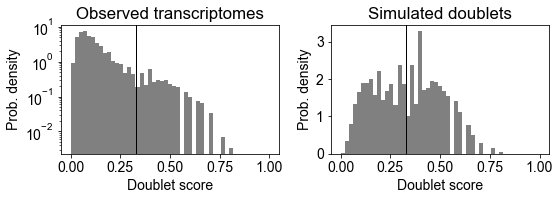

In [7]:
predicted_doublets_z = scrub_z.call_doublets(threshold=0.33)
scrub_z.plot_histogram();

*Repeat using log transformation with no z-scoring:*

In [8]:
scrub_log = scr.Scrublet(counts_matrix, expected_doublet_rate=expected_doublet_rate)
doublet_scores_log, predicted_doublets_log = scrub_log.scrub_doublets(n_prin_comps=30, 
                                                                      mean_center=False, 
                                                                      normalize_variance=False,
                                                                      log_transform=True
                                                                     )

Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.07
Detected doublet rate = 20.3%
Estimated detectable doublet fraction = 96.5%
Overall doublet rate:
	Expected   = 12.2%
	Estimated  = 21.0%
Elapsed time: 12.8 seconds


*For the log-transformed version, the simulated doublet score histogram is less bimodal. Set the threshold to cut off the left tail.*

Detected doublet rate = 13.1%
Estimated detectable doublet fraction = 89.8%
Overall doublet rate:
	Expected   = 12.2%
	Estimated  = 14.5%


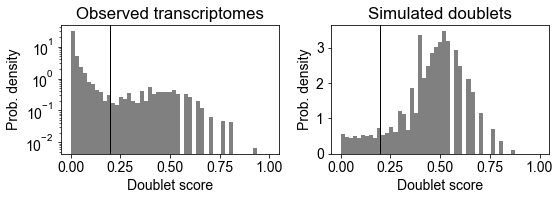

In [9]:
predicted_doublets_log = scrub_log.call_doublets(threshold=0.2)
scrub_log.plot_histogram();

#### Compare the methods

In [10]:
doub_scores = {'Scrublet (z-score)': scrub_z.doublet_scores_obs_,
               'Scrublet (log)': scrub_log.doublet_scores_obs_
              }

doub_calls = {'Demuxlet': demuxlet_calls,
              'Scrublet (z-score)': scrub_z.predicted_doublets_, 
              'Scrublet (log)': scrub_log.predicted_doublets_
              }

Compute some metrics to compare predictions to ground truth.  
For this dataset, log transformation gives better recall without hurting precision.

In [11]:
from sklearn.metrics import roc_auc_score

print('{:20s} Recall\tPrecision\tAUC'.format('Method'))
for method in doub_scores:
    recall = (doub_calls['Demuxlet'] & doub_calls[method]).sum() / doub_calls['Demuxlet'].sum()
    precision = (doub_calls['Demuxlet'] & doub_calls[method]).sum() / doub_calls[method].sum()
    roc = roc_auc_score(doub_calls['Demuxlet'], doub_scores[method])
    print('{:20s} {:.3f}\t{:.3f}\t\t{:.3f}'.format(method, recall, precision, roc))
    

Method               Recall	Precision	AUC
Scrublet (z-score)   0.465	0.658		0.874
Scrublet (log)       0.787	0.645		0.930


#### Use UMAP to visualize the results, comparing to the Demuxlet "ground truth"

In [14]:
n_umap_neighbors = 15

scrub_z.set_embedding('UMAP', scr.get_umap(scrub_z.manifold_obs_, n_umap_neighbors))
scrub_log.set_embedding('UMAP', scr.get_umap(scrub_log.manifold_obs_, n_umap_neighbors))

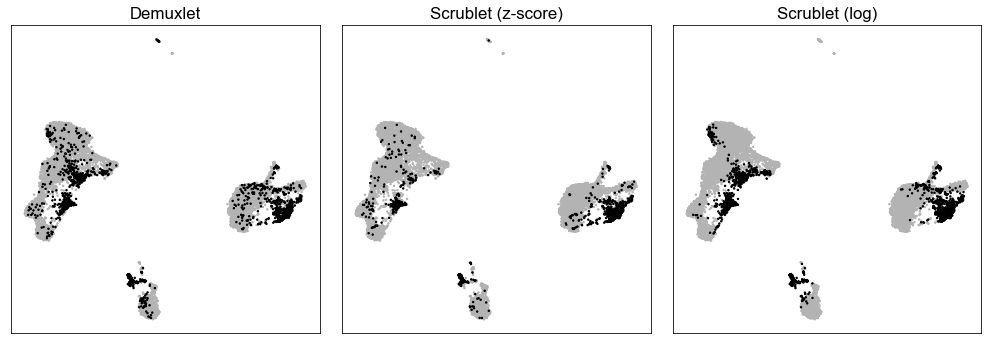

In [15]:
x = scrub_log._embeddings['UMAP'][:,0]
y = scrub_log._embeddings['UMAP'][:,1]

fig, axs = plt.subplots(1, 3, figsize = (14, 5))
for iMethod, method in enumerate(doub_calls):
    coldat = doub_calls[method]
    o = np.argsort(coldat)

    ax = axs[iMethod]
    ax.scatter(x[o], y[o], c = coldat[o], cmap=scr.custom_cmap([[.7,.7,.7], [0,0,0]]), s = 2)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(method)
fig.tight_layout()